In [ ]:
#from selenium import webdriver
#import chromedriver_autoinstaller
from bs4 import BeautifulSoup
import glob, re, os, sys, random, textract, requests, time, shutil
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.svm import LinearSVC
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_recall_fscore_support
from sklearn.feature_extraction import text
from sklearn.feature_extraction.text import TfidfVectorizer
from random import shuffle

## 1. Descarga de sentencias

In [ ]:
i=0
#888 pantallas que navegar dentro de la web
for n in range(888):
    n+=1
    url=f'https://www.tribunalconstitucional.es/es/jurisprudencia/Paginas/resultados-busqueda-sentencias.aspx?pn={n}'

    #Solicitar acceso a la URL y obtener objeto de respuesta Requests URL and get response object
    response = requests.get(url)

    #Parsear el codigo HTML
    soup = BeautifulSoup(response.text, 'html.parser')

    #Encontrar todos los hiperlinks presentes en la web
    links = soup.find_all('a')
    
    #Para cada uno de los hiperlinks, buscar links con formato pdf y descargar el archivo
    for link in links:
        if ('.pdf' in link.get('href', [])):
            i += 1
            print('Descargando archivo: ', i)

            #Obtener el objeto de respuesta
            response = requests.get(link.get('href'))

            #Escribir el contenido en un archivo pdf
            pdf = open('/Users/carlosortega/Desktop/TFG Analytics/PDFs/pdf'+ str(i) + '.pdf', 'wb')
            pdf.write(response.content)
            pdf.close()
            print('Archivo ', i, ' descargado')

## 2. Crear archivos de texto a partir de los archivos PDF

In [ ]:
for i in range(8840): #Número de documentos pdf
    i+=1
    try: #Si da error algun PDF no se detiene el loop
        text = textract.process('/Users/carlosortega/Desktop/TFG Analytics/PDFs/pdf'+ str(i) +'.pdf')
        f = open(os.path.join('/Users/carlosortega/Desktop/TFG Analytics/Textos', str(i) + '.txt'), "wb")
        f.write(text)
        f.close()
    except:
        pass

## 3. Clasificación de sentencias


In [ ]:
sentencias = pd.DataFrame({'documento':[],'articulo':[],'tipo_caso':[],'decision':[]})
cases = glob.glob('/Users/carlosortega/Desktop/TFG Analytics/Textos/*.txt')


for case in cases:
    fallo = []
    intro = []
    articulos = []
    decision = []
    print(case)
    with open(case, 'r') as f:
        wr = 0
        starts = 'SENTENCIA'
        ends = 'Antecedentes'
        contline=''
        for line in f:    #Busca la introduccion de la sentencia
            if wr == 0:
                if re.match(starts, line) != None:  #Encuentra el inicio de la introduccion
                    wr = 1
            if wr == 1 and re.search(ends, line) == None:  #Encuentra el final del FALLO de la sentencia
                contline += line
                contline += '\n'
            elif re.search(ends, line) != None:
                break
        intro.append(contline)
        
        ab = []
        for line in intro:                  #Busca qué tipo de asunto trata la sentencia
            aa = re.search('((?:R|r)ecurso\s* de\s* inconstitucionalidad|'\
                   '(?:C|c)uesti.*\s* de\s* inconstitucionalidad|'\
                   'demanda de amparo|'\
                   '(?:R|r)ecurso\s* de\s* amparo|'\
                   '(?:C|c)onflicto\s* de\s* competencia|'\
                   'de\s* amparo\s* [0-9]{1,5}-[0-9]{1,4}|'\
                   'amparo\s* [0-9]{1,5}-[0-9]{1,4}|'\
                   'de\s* inconstitucionalidad\s* [0-9]{1,5}-[0-9]{1,4}|'\
                   'inconstitucionalidad\s* [0-9]{1,5}-[0-9]{1,4})', line)
            if aa != None:
                ab.append(aa[0])
        if not ab:            #Si no hace match, lo dejamos para posterior revision manual
            ab.append('Revisar_tipo_caso')
    
        tipo_caso = re.search('(amparo|inconstitucionalidad|Revisar_tipo_caso|competencia)',ab[0])[0]
        
        print(tipo_caso)
        
        wr = 0
        starts = 'FALLO'
        ends ='Publíquese esta sentencia en el «Boletín Oficial del Estado».'
        contline = ''
        for line in f:    #Busca el FALLO de la sentencia
            if wr == 0:
                if re.match(starts, line) != None:  #Encuentra el inicio del FALLO
                    wr = 1
            if wr == 1 and re.search(ends, line) == None:  #Encuentra el final del FALLO
                contline += line
                contline += '\n'
            elif re.search(ends, line) != None:
                break
        fallo.append(contline)                     
        
        for line in fallo:
            articulo = re.findall('((?:art.*)?\s*[0-9]{1,3}.* (?:CE|Constitución))', line)  #Busca todos los articulos de la CE en el FALLO
            articulos.append(articulo)
            
        clean_art = []
        for art in articulos[0]:
            clean = re.search('[0-9]{1,3}.?[0-9]{1,3}', art)
            try:
                clean_art.append(clean[0])
            except:
                pass
        
        clean_art = set(clean_art) #Cogemos una lista de los articulos sin duplicados
        
        if len(clean_art)>3:       #Aquellas sentencias donde se nombren muchos articulos, las dejamos para revision
            clean_art=[]
        
        for line in fallo:
            dec = re.search('(?:E|e)stimar|(?:A|a)dmitir|(?:D|d)enegar el amparo|(?:D|d)esestimar|(?:I|i)nadmitir|(?:O|o)torgar|ha sido vulnerado', line)
            if dec != None:
                decision.append(dec[0])
                break
        if not decision:
            decision.append('Revisar_decision')
            
        print(f'Decision antes: {decision}')
        
        if decision[0].lower() in ['estimar','admitir', 'otorgar']:
            decision = ['Favorable']
        if decision[0].lower() in ['desestimar', 'inadmitir', 'ha sido vulnerado', 'denegar el amparo']:
            decision = ['Desfavorable']
        
        print(f'Decision despues: {decision}')
        
        #path_cwd = os.getcwd()
        path_cwd = '/Users/carlosortega/Desktop/TFG Analytics'
        
        if not clean_art: #Sentencias donde no se detecte ningun articulo
            new_path = path_cwd + '/Articulos' + '/No_articulo_detectado' + '/' + tipo_caso + '/' + decision[0]
            print(new_path)
            if not os.path.exists(new_path): #Check por si ese directorio ya existe
                    os.makedirs(new_path)      #Si no, lo creamos

            shutil.copy(case, new_path)
        else:    
            for i in clean_art:
                sentencias = sentencias.append({"documento":re.search('[0-9]{1,4}.*',case[-8:])[0],
                             "articulo":i,
                             "tipo_caso":tipo_caso,
                             "decision":decision[0]},
                             ignore_index=True)
                print(i)
                new_path = path_cwd + '/Articulos' + '/Articulo' + ' ' + i + '/' + tipo_caso + '/' + decision[0]
                print(new_path)
                if not os.path.exists(new_path): #Check por si ese directorio ya existe
                    os.makedirs(new_path)      #Si no, lo creamos

                shutil.copy(case, new_path)

In [23]:
sentencias.groupby(['articulo','tipo_caso','decision']).documento.count().sort_values(ascending=False).head(30)

articulo  tipo_caso             decision    
24.1      amparo                Favorable       842
24.2      amparo                Favorable       316
14        amparo                Favorable       169
24.1      amparo                Desfavorable    120
23.2      amparo                Favorable        98
17.1      amparo                Favorable        70
24        amparo                Favorable        68
25.1      amparo                Favorable        55
23        amparo                Favorable        53
14        amparo                Desfavorable     47
28.1      amparo                Favorable        41
9.3       inconstitucionalidad  Desfavorable     37
149.1     inconstitucionalidad  Favorable        35
24.1      Revisar_tipo_caso     Favorable        35
20.1      amparo                Favorable        34
24.2      amparo                Desfavorable     32
24        amparo                Desfavorable     31
22        amparo                Favorable        30
149.1     inconstit

## Problema a comentar

Muy dificil encontrar el artículo para muchas sentencias que mencionan los artículos vulnerados durante los fundamentos jurídicos, de maneras muy variadas, y no en el FALLO

In [25]:
recuento_sentencias = sentencias.groupby(['articulo','tipo_caso','decision']).documento.count().sort_values(ascending=False).reset_index()

In [31]:
recuento_sentencias[recuento_sentencias.documento>30].groupby(['articulo','tipo_caso']).documento.count()>1

articulo  tipo_caso           
14        amparo                   True
149.1     inconstitucionalidad    False
17.1      amparo                  False
20.1      amparo                  False
23        amparo                  False
23.2      amparo                  False
24        amparo                   True
24.1      Revisar_tipo_caso       False
          amparo                   True
24.2      amparo                   True
25.1      amparo                  False
28.1      amparo                  False
9.3       inconstitucionalidad    False
Name: documento, dtype: bool

In [35]:
recuento_sentencias[recuento_sentencias.documento>30].groupby(['articulo','tipo_caso']).agg({'documento':['count',
                                                                                                          'min',
                                                                                                          'max']})

documento          
                                  count  min  max
articulo tipo_caso                               
14       amparo                       2   47  169
149.1    inconstitucionalidad         1   35   35
17.1     amparo                       1   70   70
20.1     amparo                       1   34   34
23       amparo                       1   53   53
23.2     amparo                       1   98   98
24       amparo                       2   31   68
24.1     Revisar_tipo_caso            1   35   35
         amparo                       2  120  842
24.2     amparo                       2   32  316
25.1     amparo                       1   55   55
28.1     amparo                       1   41   41
9.3      inconstitucionalidad         1   37   37

Unicamente crearé modelos para la combinación de artículo-tipo de caso que tenga un dataset con suficientes casos tanto '

## 4. Balanced dataset


Training set:
- Coger la categoria con menos casos como número de referencia. Split del 80% entre train set y test set.

Test set:
- Probar tanto:
    - Balanced test set
    - Unbalanced test set --> No medir accuracy sino sensitividad y especificidad

In [40]:
articulos_mod = ['Articulo 14', 'Articulo 24.1', 'Articulo 24.2']
caso_mod = 'amparo'


for art in articulos_mod:
    print(f'{art}:')
    #Creo las carpetas para separar las sentencias que se usarán para entrenamiento y para test
    for decision in ['Favorable', 'Desfavorable']:

        new_path_train = '/Users/carlosortega/Desktop/TFG Analytics/train/' + caso_mod + '/' + decision + '/' + art
        new_path_test = '/Users/carlosortega/Desktop/TFG Analytics/test/' + caso_mod + '/' + decision + '/' + art

        os.makedirs(new_path_train)
        os.makedirs(new_path_test)
    
    #Cogemos todos los casos favorables y desfavorables para cada artículo
    casos_fav = glob.glob(f'/Users/carlosortega/Desktop/TFG Analytics/Articulos/{art}/{caso_mod}/Favorable/*.txt')
    casos_desfav = glob.glob(f'/Users/carlosortega/Desktop/TFG Analytics/Articulos/{art}/{caso_mod}/Desfavorable/*.txt')    
    
    print(f'{len(casos_fav)} casos favorables \n{len(casos_desfav)} casos desfavorables\n')
    
    min_casos = min([len(casos_fav),len(casos_desfav)])
    train_n = round(min_casos*0.8)  #Numero de sentencias de cada categoría (Favorable o Desfavorable) para entrenar el modelo
    
    #Seleccionamos aleatoriamente las sentencias
    casos_fav_train = random.sample(casos_fav,train_n)
    casos_fav_test = [x for x in casos_fav if x not in casos_fav_train]
    casos_desfav_train = random.sample(casos_desfav,train_n)
    casos_desfav_test = [x for x in casos_desfav if x not in casos_desfav_train]
    
    print(f'\tCasos entrenamiento: \n\t\t{len(casos_fav_train)} favorables\n\t\t{len(casos_desfav_train)} desfavorables\n')
    print(f'\tCasos test: \n\t\t{len(casos_fav_test)} favorables\n\t\t{len(casos_desfav_test)} desfavorables\n\n')
    
    new_path_fav_train = '/Users/carlosortega/Desktop/TFG Analytics/train/' + caso_mod + '/Favorable/' + art
    for caso in casos_fav_train:
        shutil.copy(caso, new_path_fav_train)
    
    new_path_fav_test = '/Users/carlosortega/Desktop/TFG Analytics/test/' + caso_mod + '/Favorable/' + art
    for caso in casos_fav_test:
        shutil.copy(caso, new_path_fav_test)
        
    new_path_desfav_train = '/Users/carlosortega/Desktop/TFG Analytics/train/' + caso_mod + '/Desfavorable/' + art
    for caso in casos_desfav_train:
        shutil.copy(caso, new_path_desfav_train)
    
    new_path_desfav_test = '/Users/carlosortega/Desktop/TFG Analytics/test/' + caso_mod + '/Desfavorable/' + art
    for caso in casos_desfav_test:
        shutil.copy(caso, new_path_desfav_test)

Articulo 14:
169 casos favorables 
47 casos desfavorables

	Casos entrenamiento: 
		38 favorables
		38 desfavorables

	Casos test: 
		131 favorables
		9 desfavorables


Articulo 24.1:
842 casos favorables 
120 casos desfavorables

	Casos entrenamiento: 
		96 favorables
		96 desfavorables

	Casos test: 
		746 favorables
		24 desfavorables


Articulo 24.2:
316 casos favorables 
32 casos desfavorables

	Casos entrenamiento: 
		26 favorables
		26 desfavorables

	Casos test: 
		290 favorables
		6 desfavorables




## 5. Pipeline del modelo

A través de este pipeline:

- Extraeremos cada parte de las sentencias
- Entrenaremos el modelo eligiendo usar 10-fold cross validation
    - También podremos elegir si queremos que el test set este equilibrado o no (en el caso de hacer cross validation, deberá estar equilibrado)
- Sacaremos las 30 variables con mayor peso
- Validaremos el modelo con el test set
- Evaluaremos el modelo con distintas métricas

In [46]:
def extract_text(starts, ends, cases, violation):
    facts = []
    D = []
    years = []
    for case in cases:
        contline = ''
        year = 0
        with open(case, 'r') as f:
            for line in f:
                dat = re.search(r'\b\d{4}\b', line)
                if dat != None:
                    year = int(dat[0])
                    break
            if year>0:
                years.append(year)
                wr = 0
                for line in f:
                    if wr == 0:
                        if re.search(starts, line) != None:
                            wr = 1
                    if wr == 1 and re.search(ends, line) == None:
                        contline += line
                        contline += '\n'
                    elif re.search(ends, line) != None:
                        break
                facts.append(contline)
    for i in range(len(facts)):
        D.append((facts[i], violation, years[i])) 
    return D

In [47]:
def extract_parts(train_path, violation, part): #extract text from different parts
    cases = glob.glob(train_path)

    facts = []
    D = []
        
    if part == 'intro+composicion_tribunal':
        starts = 'TRIBUNAL CONSTITUCIONAL'
        ends ='SENTENCIA'
        D = extract_text(starts, ends, cases, violation)
    if part == 'contexto':
        starts = 'SENTENCIA'
        ends ='Antecedentes'
        D = extract_text(starts, ends, cases, violation)
    if part == 'antecedentes':
        starts = 'Antecedentes'
        ends ='Fundamentos jur(?:í|i)dicos'
        D = extract_text(starts, ends, cases, violation)
    if part == 'fundamentos':
        starts = 'Fundamentos jur(?:í|i)dicos'
        ends ='FALLO'
        D = extract_text(starts, ends, cases, violation)
    if part == 'antecedentes+fundamentos':
        starts = 'Antecedentes'
        ends ='FALLO'
        D = extract_text(starts, ends, cases, violation)
    if part == 'todo':
        starts = 'TRIBUNAL CONSTITUCIONAL'
        ends = 'FALLO'
        D = extract_text(starts, ends, cases, violation)
    return D

In [214]:
def train_model_cross_val(Xtrain, Ytrain, Xtest, Ytest, vec, c): #Linear SVC model cross-validation
    print('***10-fold cross-validation***')
    pipeline = Pipeline([
        ('features', FeatureUnion(
            [vec],
        )),
        ('classifier', LinearSVC(C=c))
        ])
    X = Xtrain + Xtest
    Y = Ytrain + Ytest
    Ypredict = cross_val_predict(pipeline, X, Y, cv=5) #5-fold cross-validation
    evaluate(Y, Ypredict)

In [201]:
def train_model_test(Xtrain, Ytrain, Xtest, Ytest, vec, c):
    
    #Pipeline para encadenar los distintos steps que debe llevar a cabo el modelo
    pipeline = Pipeline([
        ('features', FeatureUnion([vec]
        )),
        ('classifier', LinearSVC(C=c,))
        ])
    
    #Entrenamiento del modelo
    pipeline.fit(Xtrain, Ytrain)
    print('***TEST***')
    
    #Test sobre datos nuevos
    Ypredict = pipeline.predict(Xtest)
    
    print(pipeline.classes_) 
    
    #Información sobre el feature importance
    variables = pipeline.named_steps['features'].get_feature_names()
    coeficientes = pipeline.named_steps['classifier'].coef_.flatten()
    
    #Dataframe agrupando variables y sus coeficientes
    zipped = zip(variables, coeficientes)
    df_variables = pd.DataFrame(zipped, columns=["feature", "value"])
    
    #Color rojo para coeficientes negativos y verde para positivos
    df_variables["colors"] = df_variables["value"].apply(lambda x: "green" if x > 0 else "red")
    
    #Ordenamos las variables por el valor absoluto de su coeficiente
    df_variables["abs_value"] = df_variables["value"].apply(lambda x: abs(x))
    df_variables = df_variables.sort_values("abs_value", ascending=False)
    
    fig, ax = plt.subplots(figsize=(15, 5))
    sns.barplot(x="feature",
                y="value",
                data=df_variables.head(30),
               palette=df_variables.head(30)["colors"])
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90, fontsize=20)
    ax.set_title("Top 30 Variables", fontsize=25)
    ax.set_ylabel("Coeficiente", fontsize=22)
    ax.set_xlabel("Nombre variables", fontsize=22)
    plt.show()
    
    evaluate(Ytest, Ypredict)

In [167]:
def evaluate(Ytest, Ypredict): #evaluar el modelo the model (accuracy, precision, recall, f-score, confusion matrix)
        print('Accuracy:', accuracy_score(Ytest, Ypredict) )
        print('\nClassification report:\n', classification_report(Ytest, Ypredict))
        print('\nCR:', precision_recall_fscore_support(Ytest, Ypredict, average='macro'))
        print('\nMatriz de confusion:\n', confusion_matrix(Ytest, Ypredict))

        ax= plt.subplot()
        sns.heatmap(confusion_matrix(Ytest, Ypredict), annot=True, fmt='g', ax=ax) #annot=True para ver los valores de cada celda y fmt='g' para evitar notación científica

        ax.set_xlabel('Etiqueta predicha')
        ax.set_ylabel('Etiqueta real')
        ax.set_title('Matriz de Confusión')
        ax.xaxis.set_ticklabels(['Desfavorable', 'Favorable'])
        ax.yaxis.set_ticklabels(['Desfavorable', 'Favorable'])
        ax.yaxis.set_tick_params(rotation=0)
        plt.show()
        
        print('\n\n_______________________\n\n')

In [220]:
def run_pipeline(part, vec, c): #run tests
    
    print('Entrenado sobre: ' + part + '\n')
    
    #Sentencias para entrenamiento
    train_fav = extract_parts(path+'train/'+article+'/amparo/Favorable/*.txt', 'favorable', part)
    train_desfav = extract_parts(path+'train/'+article+'/amparo/Desfavorable/*.txt', 'desfavorable', part)
    trainset = train_fav+train_desfav
    shuffle(trainset)

    Xtrain = [i[0] for i in trainset]
    Ytrain = [i[1] for i in trainset]
    
    #Sentencias para test
    test_fav = extract_parts(path+'test/'+article+'/amparo/Favorable/*.txt', 'favorable', part)
    test_desfav = extract_parts(path+'test/'+article+'/amparo/Desfavorable/*.txt', 'desfavorable', part)
    testset = test_fav+test_desfav
    shuffle(testset)
    
    Xtest = [i[0] for i in testset]
    Ytest = [i[1] for i in testset]


    print('Entrenando sobre', Ytrain.count('favorable'),'casos favorables +', Ytrain.count('desfavorable'), 'casos desfavorables =', Ytrain.count('favorable') + Ytrain.count('desfavorable'), 'cases', '\nSentencias disponibles para testear:', Ytest.count('favorable'), 'favorables +', Ytest.count('desfavorable'),' desfavorables')
    train_model_test(Xtrain, Ytrain, Xtest, Ytest, vec, c)
    #train_model_cross_val(Xtrain, Ytrain, Xtest, Ytest, vec, c) #use for cross-validation

### 

In [ ]:
import nltk
nltk.download()

## 6. Modelos para cada artículo y para cada parte de la sentencia (Training + Validation)

En este caso estoy probando un test set unbalanced, otras variantes que he probado han sido:
- Balanced test set
- Balanced test set incluyendo las sentencias del artículo 24 a los datasets de los artículos 24.1 y 24.2
- Balanced test set probando cross validation

Articulo 24.1
_________________
_________________

Entrenado sobre: intro+composicion_tribunal

Entrenando sobre 96 casos favorables + 96 casos desfavorables = 192 cases 
Sentencias disponibles para testear: 746 favorables + 24  desfavorables
***TEST***
['desfavorable' 'favorable']


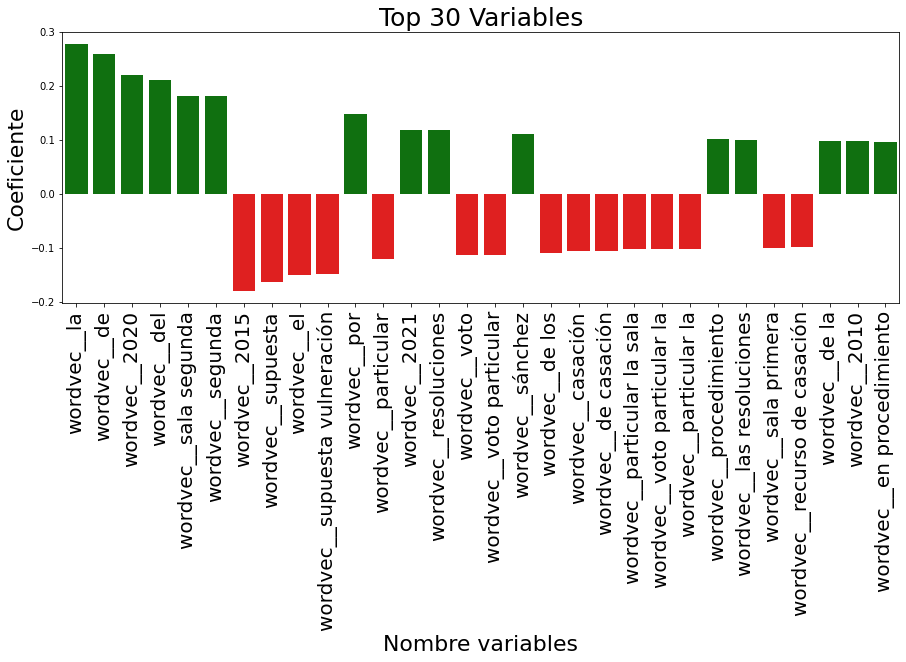

Precision: 0.5233766233766234

Classification report:
               precision    recall  f1-score   support

desfavorable       0.06      0.92      0.11        24
   favorable       0.99      0.51      0.67       746

    accuracy                           0.52       770
   macro avg       0.53      0.71      0.39       770
weighted avg       0.97      0.52      0.66       770


CR: (0.5258128065523778, 0.7136952636282394, 0.39099476530055877, None)

Matriz de confusion:
 [[ 22   2]
 [365 381]]


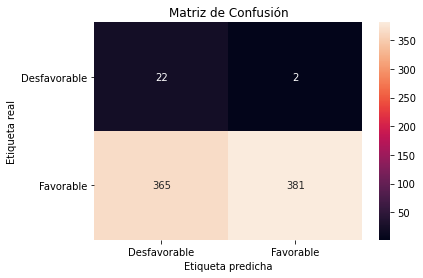



_______________________


Entrenado sobre: contexto

Entrenando sobre 96 casos favorables + 96 casos desfavorables = 192 cases 
Sentencias disponibles para testear: 746 favorables + 24  desfavorables
***TEST***
['desfavorable' 'favorable']


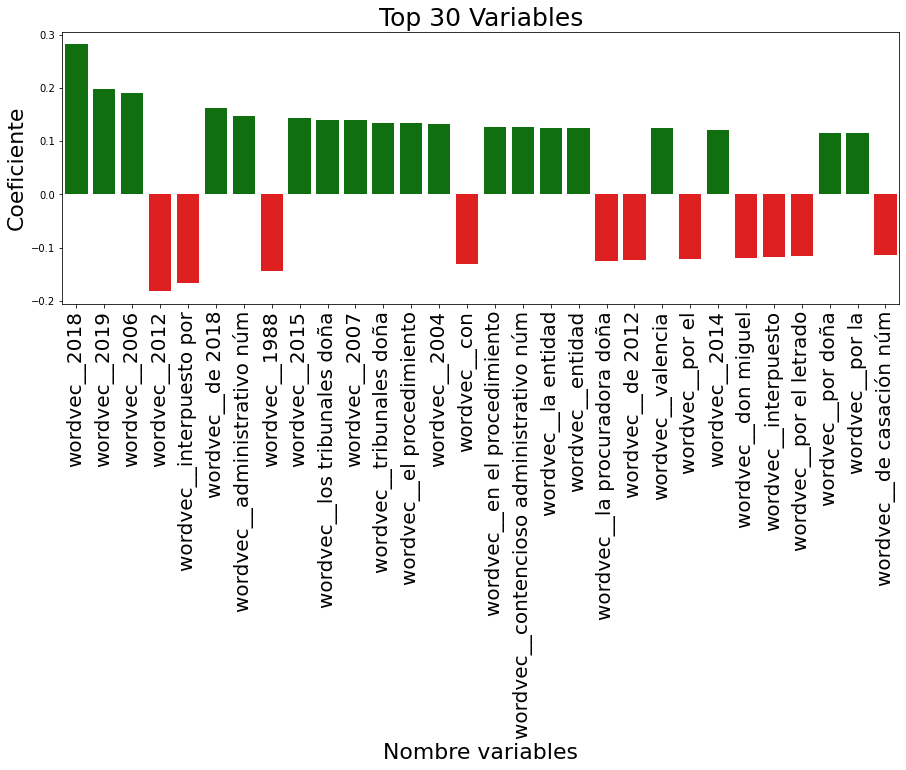

Precision: 0.7103896103896103

Classification report:
               precision    recall  f1-score   support

desfavorable       0.08      0.75      0.14        24
   favorable       0.99      0.71      0.83       746

    accuracy                           0.71       770
   macro avg       0.53      0.73      0.48       770
weighted avg       0.96      0.71      0.80       770


CR: (0.5326903957049115, 0.7295576407506703, 0.48245669557144966, None)

Matriz de confusion:
 [[ 18   6]
 [217 529]]


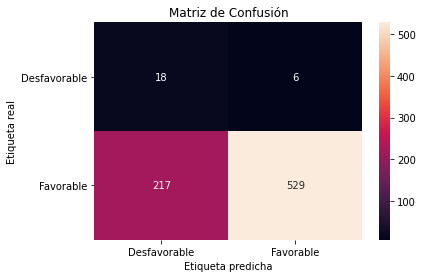



_______________________


Entrenado sobre: antecedentes

Entrenando sobre 96 casos favorables + 96 casos desfavorables = 192 cases 
Sentencias disponibles para testear: 746 favorables + 24  desfavorables
***TEST***
['desfavorable' 'favorable']


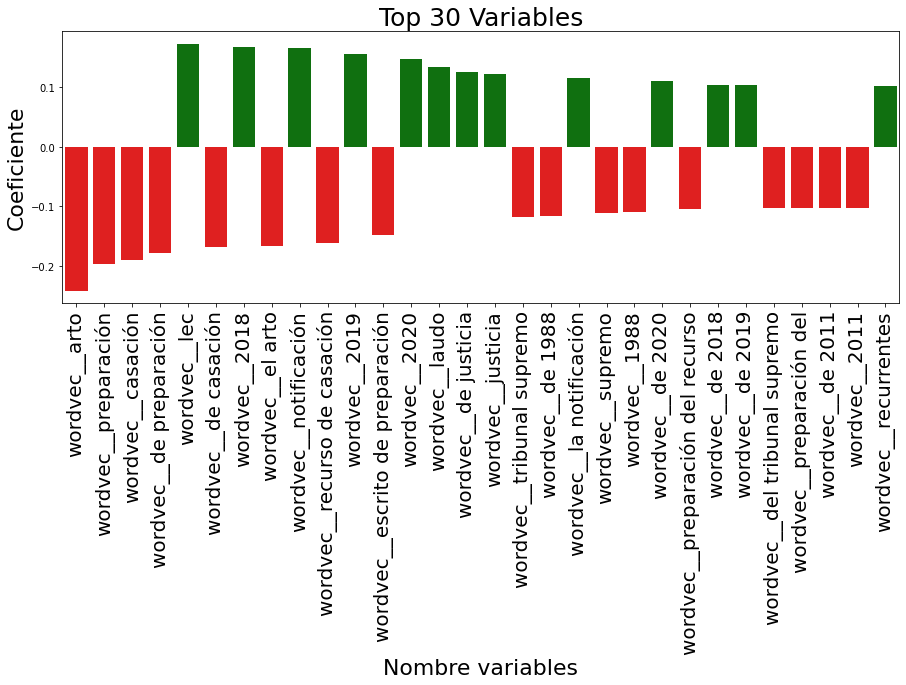

Precision: 0.7844155844155845

Classification report:
               precision    recall  f1-score   support

desfavorable       0.11      0.83      0.19        24
   favorable       0.99      0.78      0.88       746

    accuracy                           0.78       770
   macro avg       0.55      0.81      0.53       770
weighted avg       0.97      0.78      0.85       770


CR: (0.5515436944008373, 0.8080875781948168, 0.5348684880860541, None)

Matriz de confusion:
 [[ 20   4]
 [162 584]]


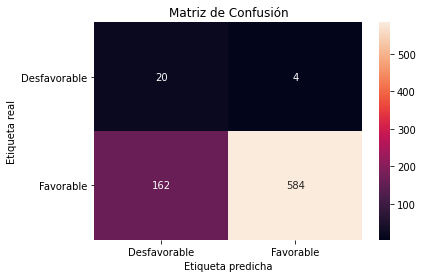



_______________________


Entrenado sobre: fundamentos

Entrenando sobre 96 casos favorables + 96 casos desfavorables = 192 cases 
Sentencias disponibles para testear: 746 favorables + 24  desfavorables
***TEST***
['desfavorable' 'favorable']


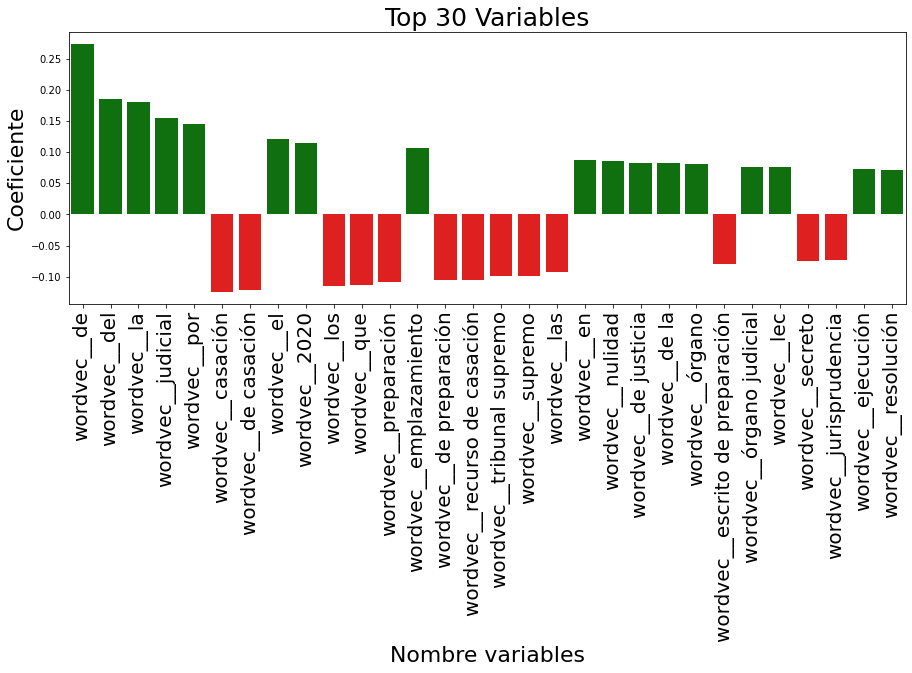

Precision: 0.6766233766233766

Classification report:
               precision    recall  f1-score   support

desfavorable       0.07      0.75      0.13        24
   favorable       0.99      0.67      0.80       746

    accuracy                           0.68       770
   macro avg       0.53      0.71      0.46       770
weighted avg       0.96      0.68      0.78       770


CR: (0.5285888489939706, 0.7121313672922251, 0.4639547074858461, None)

Matriz de confusion:
 [[ 18   6]
 [243 503]]


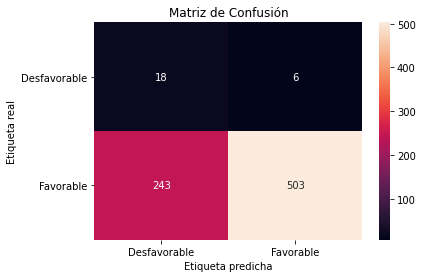



_______________________


Entrenado sobre: antecedentes+fundamentos

Entrenando sobre 96 casos favorables + 96 casos desfavorables = 192 cases 
Sentencias disponibles para testear: 746 favorables + 24  desfavorables
***TEST***
['desfavorable' 'favorable']


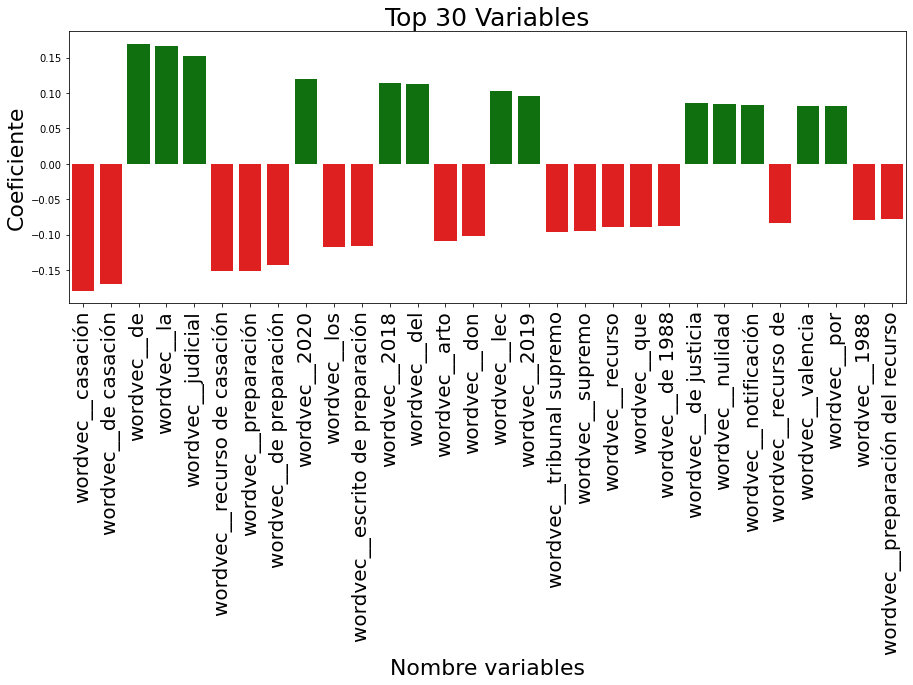

Precision: 0.6766233766233766

Classification report:
               precision    recall  f1-score   support

desfavorable       0.07      0.75      0.13        24
   favorable       0.99      0.67      0.80       746

    accuracy                           0.68       770
   macro avg       0.53      0.71      0.46       770
weighted avg       0.96      0.68      0.78       770


CR: (0.5285888489939706, 0.7121313672922251, 0.4639547074858461, None)

Matriz de confusion:
 [[ 18   6]
 [243 503]]


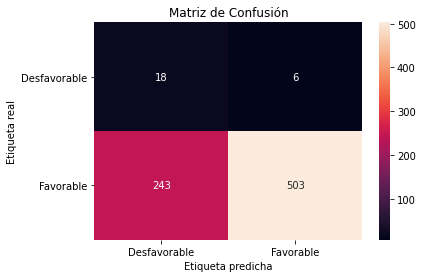



_______________________


Entrenado sobre: todo

Entrenando sobre 96 casos favorables + 96 casos desfavorables = 192 cases 
Sentencias disponibles para testear: 746 favorables + 24  desfavorables
***TEST***
['desfavorable' 'favorable']


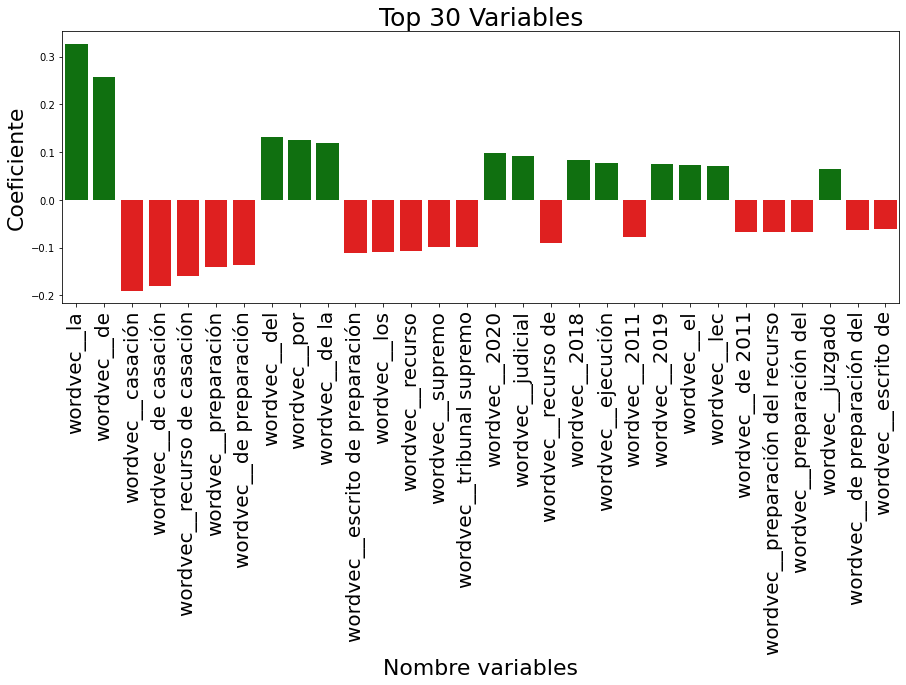

Precision: 0.5454545454545454

Classification report:
               precision    recall  f1-score   support

desfavorable       0.06      0.92      0.11        24
   favorable       0.99      0.53      0.69       746

    accuracy                           0.55       770
   macro avg       0.53      0.73      0.40       770
weighted avg       0.97      0.55      0.68       770


CR: (0.5272297297297297, 0.7250893655049151, 0.40313250236975223, None)

Matriz de confusion:
 [[ 22   2]
 [348 398]]


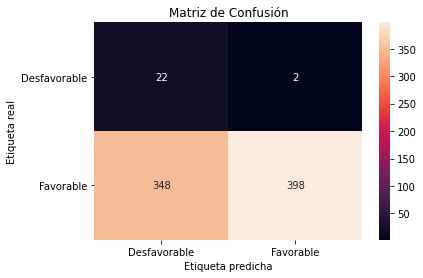



_______________________


Articulo 24.2
_________________
_________________

Entrenado sobre: intro+composicion_tribunal

Entrenando sobre 26 casos favorables + 26 casos desfavorables = 52 cases 
Sentencias disponibles para testear: 290 favorables + 6  desfavorables
***TEST***
['desfavorable' 'favorable']


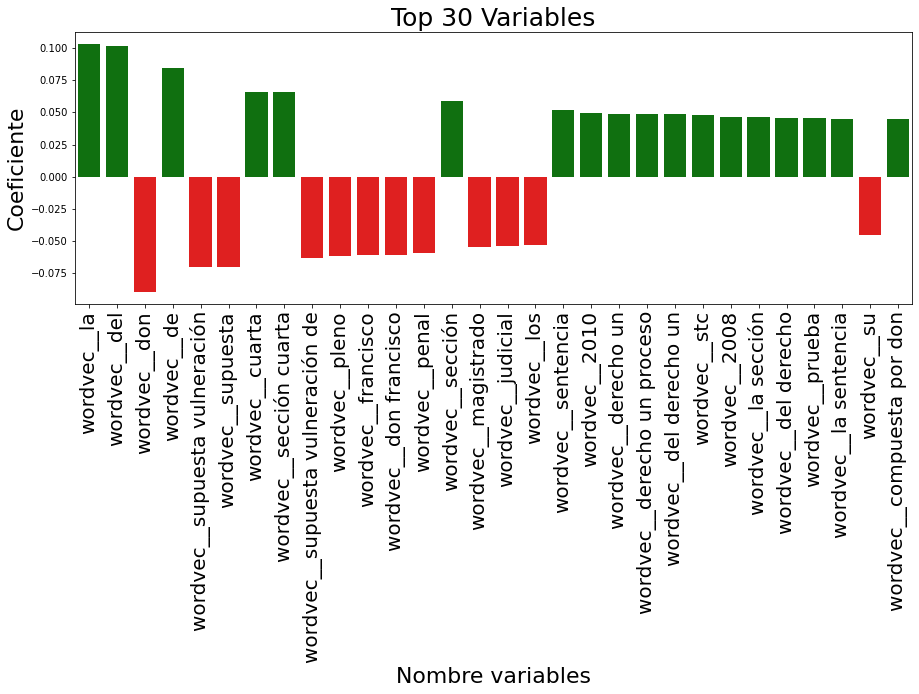

Precision: 0.5033783783783784

Classification report:
               precision    recall  f1-score   support

desfavorable       0.04      1.00      0.08         6
   favorable       1.00      0.49      0.66       290

    accuracy                           0.50       296
   macro avg       0.52      0.75      0.37       296
weighted avg       0.98      0.50      0.65       296


CR: (0.5196078431372549, 0.746551724137931, 0.36798989062704257, None)

Matriz de confusion:
 [[  6   0]
 [147 143]]


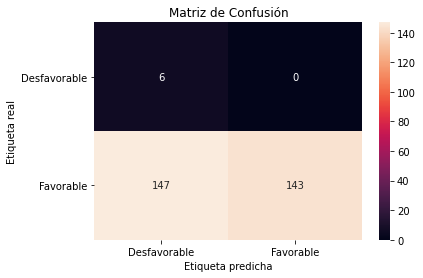



_______________________


Entrenado sobre: contexto

Entrenando sobre 26 casos favorables + 26 casos desfavorables = 52 cases 
Sentencias disponibles para testear: 290 favorables + 6  desfavorables
***TEST***
['desfavorable' 'favorable']


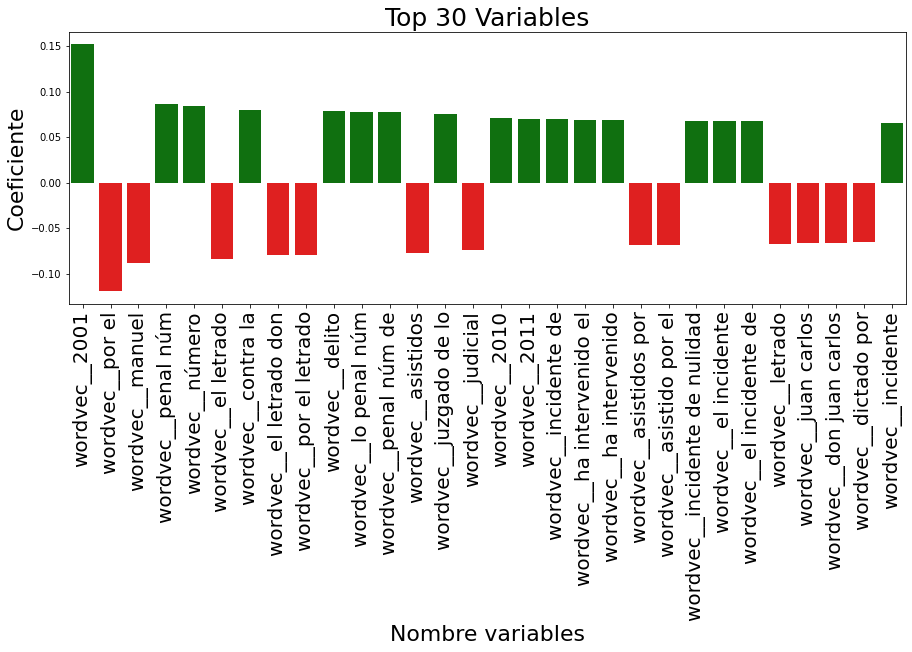

Precision: 0.6554054054054054

Classification report:
               precision    recall  f1-score   support

desfavorable       0.02      0.33      0.04         6
   favorable       0.98      0.66      0.79       290

    accuracy                           0.66       296
   macro avg       0.50      0.50      0.41       296
weighted avg       0.96      0.66      0.77       296


CR: (0.49979591836734694, 0.4977011494252873, 0.4139296529233636, None)

Matriz de confusion:
 [[  2   4]
 [ 98 192]]


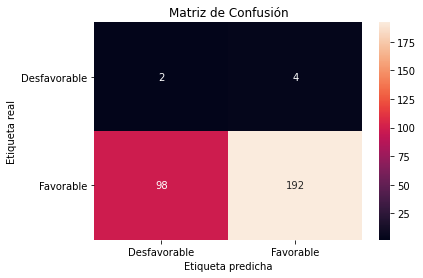



_______________________


Entrenado sobre: antecedentes

Entrenando sobre 26 casos favorables + 26 casos desfavorables = 52 cases 
Sentencias disponibles para testear: 290 favorables + 6  desfavorables
***TEST***
['desfavorable' 'favorable']


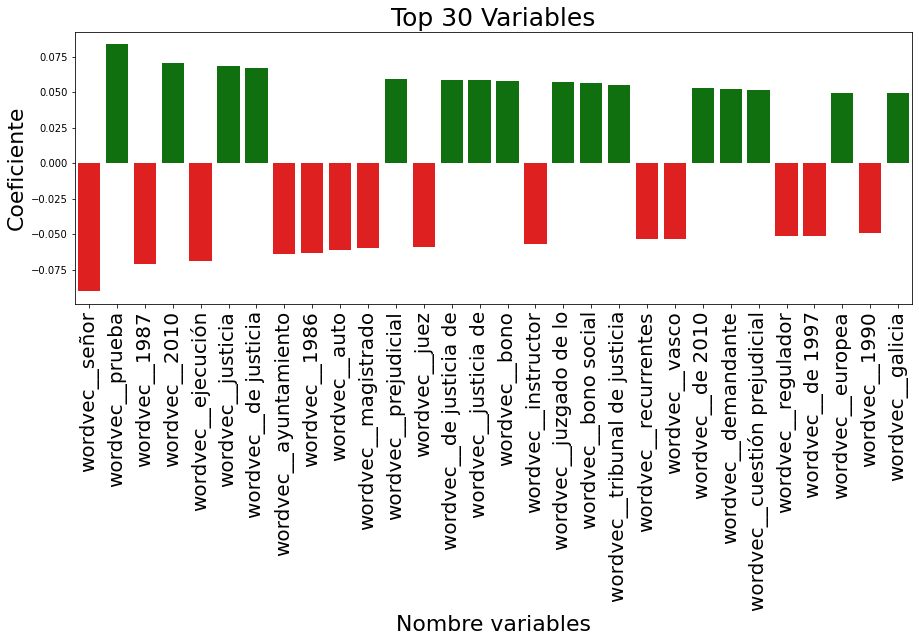

Precision: 0.7702702702702703

Classification report:
               precision    recall  f1-score   support

desfavorable       0.06      0.67      0.11         6
   favorable       0.99      0.77      0.87       290

    accuracy                           0.77       296
   macro avg       0.52      0.72      0.49       296
weighted avg       0.97      0.77      0.85       296


CR: (0.5241466498103666, 0.7195402298850575, 0.48674010607915136, None)

Matriz de confusion:
 [[  4   2]
 [ 66 224]]


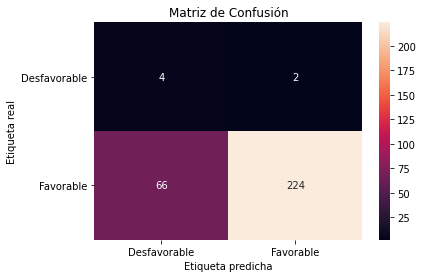



_______________________


Entrenado sobre: fundamentos

Entrenando sobre 26 casos favorables + 26 casos desfavorables = 52 cases 
Sentencias disponibles para testear: 290 favorables + 6  desfavorables
***TEST***
['desfavorable' 'favorable']


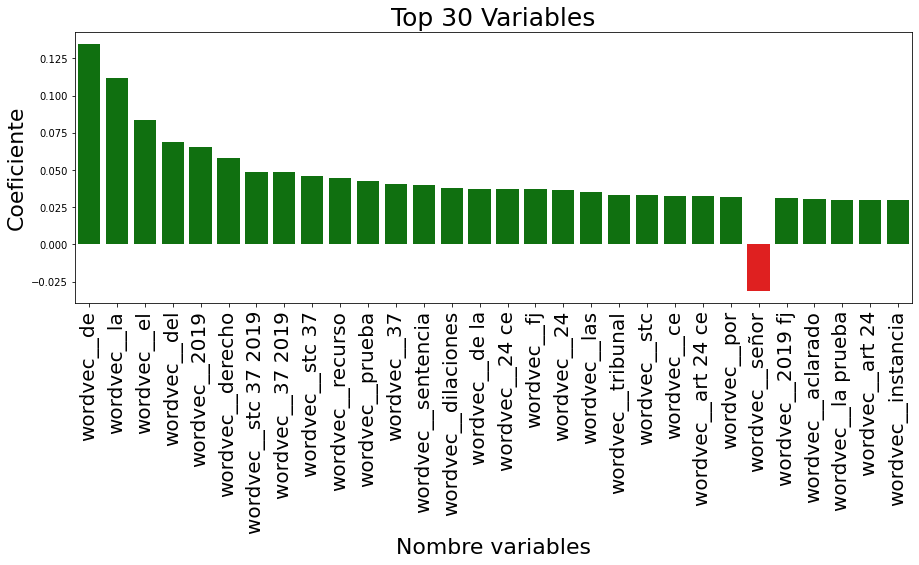

Precision: 0.7128378378378378

Classification report:
               precision    recall  f1-score   support

desfavorable       0.02      0.33      0.04         6
   favorable       0.98      0.72      0.83       290

    accuracy                           0.71       296
   macro avg       0.50      0.53      0.44       296
weighted avg       0.96      0.71      0.82       296


CR: (0.502658521409582, 0.5270114942528735, 0.4379788683628566, None)

Matriz de confusion:
 [[  2   4]
 [ 81 209]]


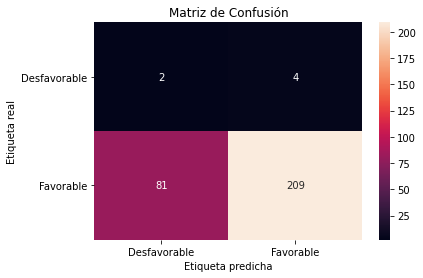



_______________________


Entrenado sobre: antecedentes+fundamentos

Entrenando sobre 26 casos favorables + 26 casos desfavorables = 52 cases 
Sentencias disponibles para testear: 290 favorables + 6  desfavorables
***TEST***
['desfavorable' 'favorable']


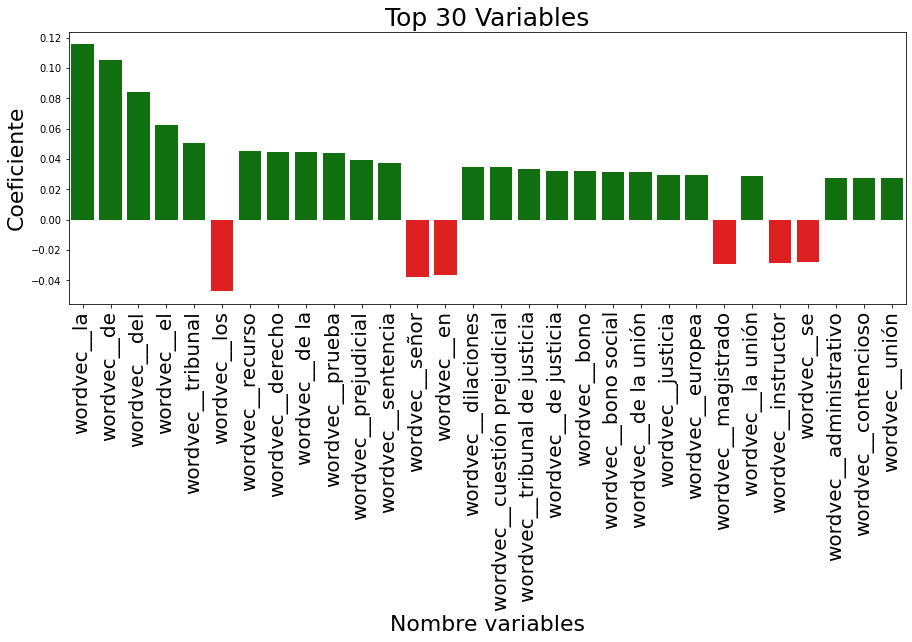

Precision: 0.7263513513513513

Classification report:
               precision    recall  f1-score   support

desfavorable       0.03      0.33      0.05         6
   favorable       0.98      0.73      0.84       290

    accuracy                           0.73       296
   macro avg       0.50      0.53      0.44       296
weighted avg       0.96      0.73      0.82       296


CR: (0.5034416379863501, 0.5339080459770115, 0.4436477549599721, None)

Matriz de confusion:
 [[  2   4]
 [ 77 213]]


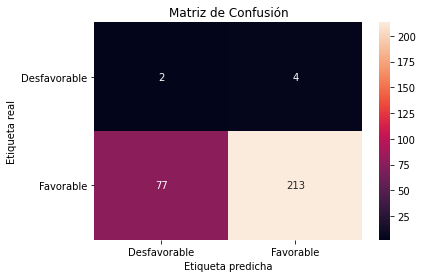



_______________________


Entrenado sobre: todo

Entrenando sobre 26 casos favorables + 26 casos desfavorables = 52 cases 
Sentencias disponibles para testear: 290 favorables + 6  desfavorables
***TEST***
['desfavorable' 'favorable']


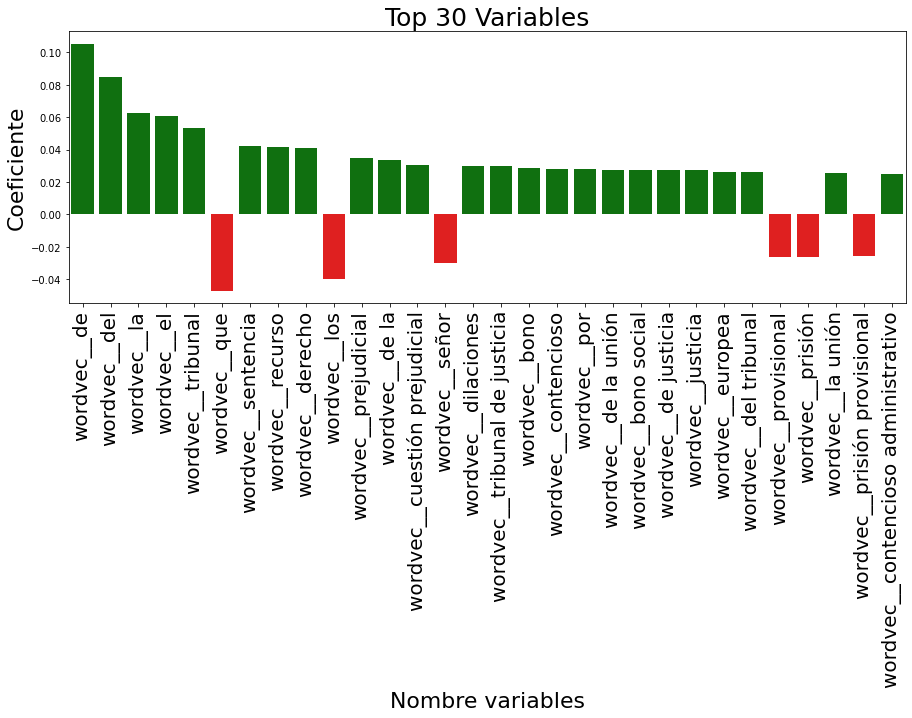

Precision: 0.5777027027027027

Classification report:
               precision    recall  f1-score   support

desfavorable       0.04      0.83      0.07         6
   favorable       0.99      0.57      0.73       290

    accuracy                           0.58       296
   macro avg       0.52      0.70      0.40       296
weighted avg       0.97      0.58      0.71       296


CR: (0.5163858329851924, 0.7028735632183909, 0.400275549072048, None)

Matriz de confusion:
 [[  5   1]
 [124 166]]


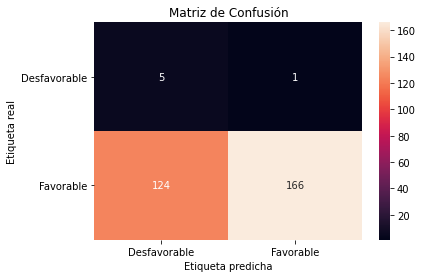



_______________________


Articulo 14
_________________
_________________

Entrenado sobre: intro+composicion_tribunal

Entrenando sobre 38 casos favorables + 38 casos desfavorables = 76 cases 
Sentencias disponibles para testear: 131 favorables + 9  desfavorables
***TEST***
['desfavorable' 'favorable']


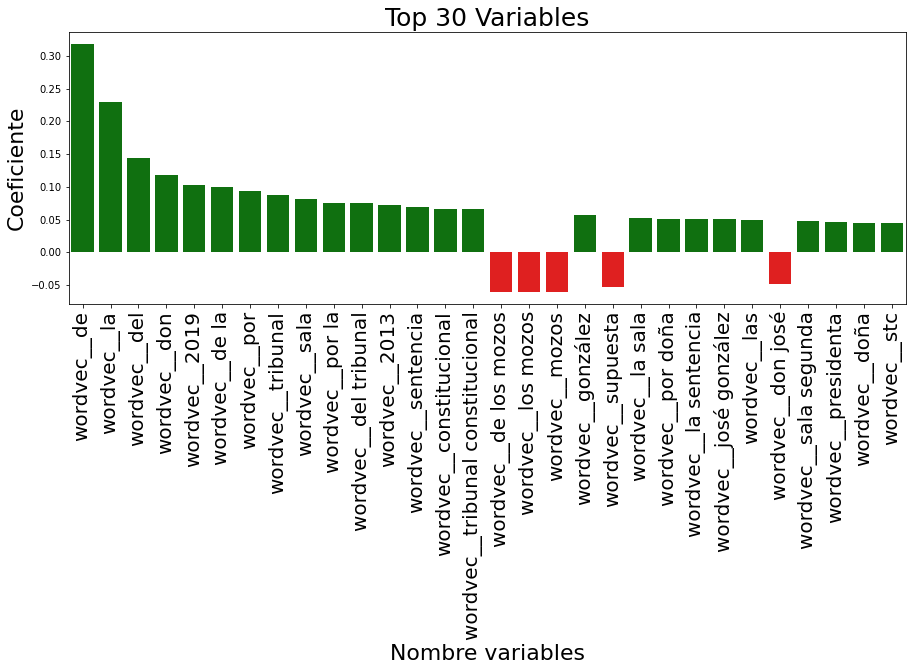

Precision: 0.5571428571428572

Classification report:
               precision    recall  f1-score   support

desfavorable       0.10      0.78      0.18         9
   favorable       0.97      0.54      0.70       131

    accuracy                           0.56       140
   macro avg       0.54      0.66      0.44       140
weighted avg       0.92      0.56      0.66       140


CR: (0.5385401758331629, 0.6598812553011026, 0.44014447884416924, None)

Matriz de confusion:
 [[ 7  2]
 [60 71]]


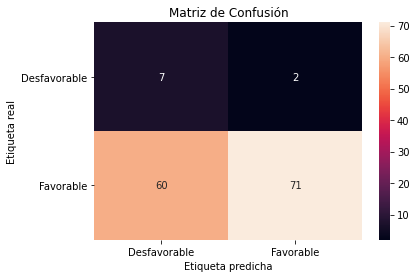



_______________________


Entrenado sobre: contexto

Entrenando sobre 38 casos favorables + 38 casos desfavorables = 76 cases 
Sentencias disponibles para testear: 131 favorables + 9  desfavorables
***TEST***
['desfavorable' 'favorable']


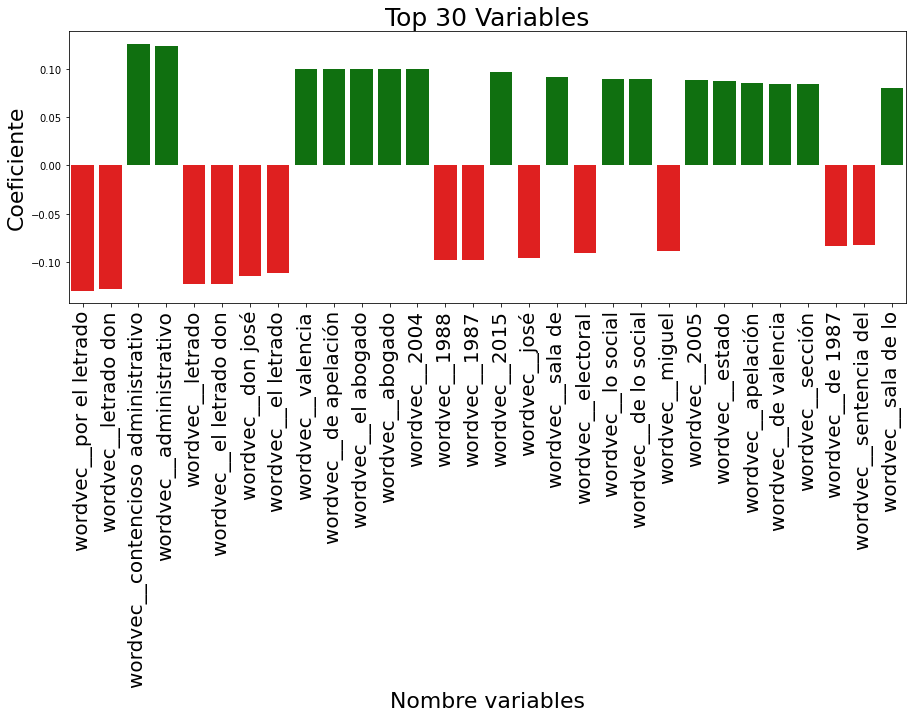

Precision: 0.6928571428571428

Classification report:
               precision    recall  f1-score   support

desfavorable       0.13      0.67      0.22         9
   favorable       0.97      0.69      0.81       131

    accuracy                           0.69       140
   macro avg       0.55      0.68      0.51       140
weighted avg       0.91      0.69      0.77       140


CR: (0.5492599444958371, 0.6806615776081425, 0.5135353535353536, None)

Matriz de confusion:
 [[ 6  3]
 [40 91]]


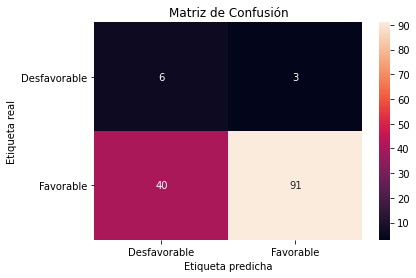



_______________________


Entrenado sobre: antecedentes

Entrenando sobre 38 casos favorables + 38 casos desfavorables = 76 cases 
Sentencias disponibles para testear: 131 favorables + 9  desfavorables
***TEST***
['desfavorable' 'favorable']


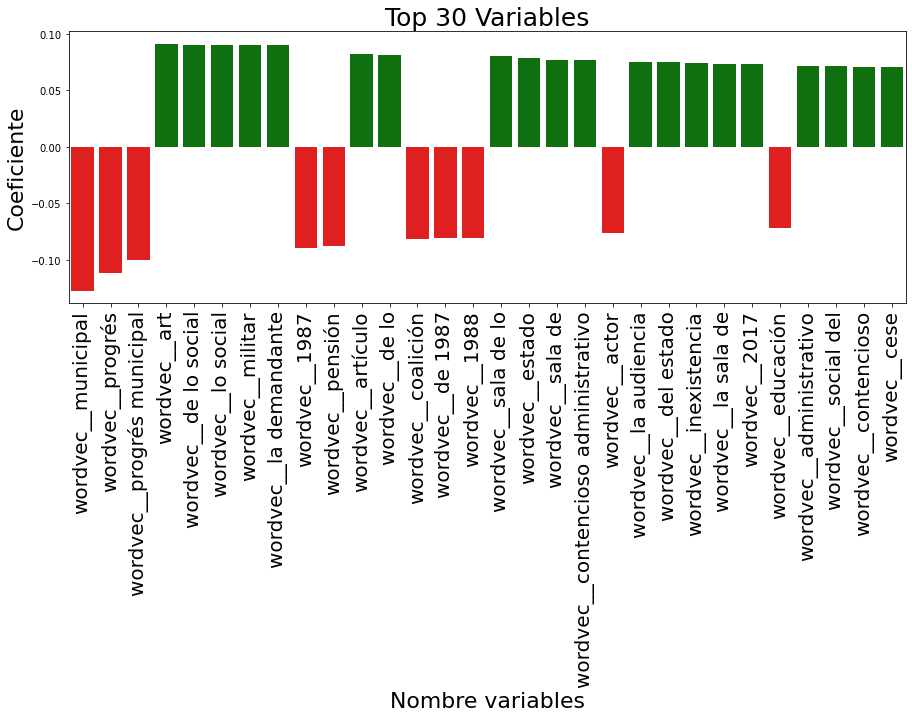

Precision: 0.7214285714285714

Classification report:
               precision    recall  f1-score   support

desfavorable       0.16      0.78      0.26         9
   favorable       0.98      0.72      0.83       131

    accuracy                           0.72       140
   macro avg       0.57      0.75      0.55       140
weighted avg       0.93      0.72      0.79       140


CR: (0.5691287878787878, 0.7476675148430874, 0.5461723879976726, None)

Matriz de confusion:
 [[ 7  2]
 [37 94]]


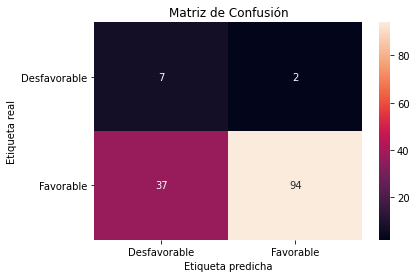



_______________________


Entrenado sobre: fundamentos

Entrenando sobre 38 casos favorables + 38 casos desfavorables = 76 cases 
Sentencias disponibles para testear: 131 favorables + 9  desfavorables
***TEST***
['desfavorable' 'favorable']


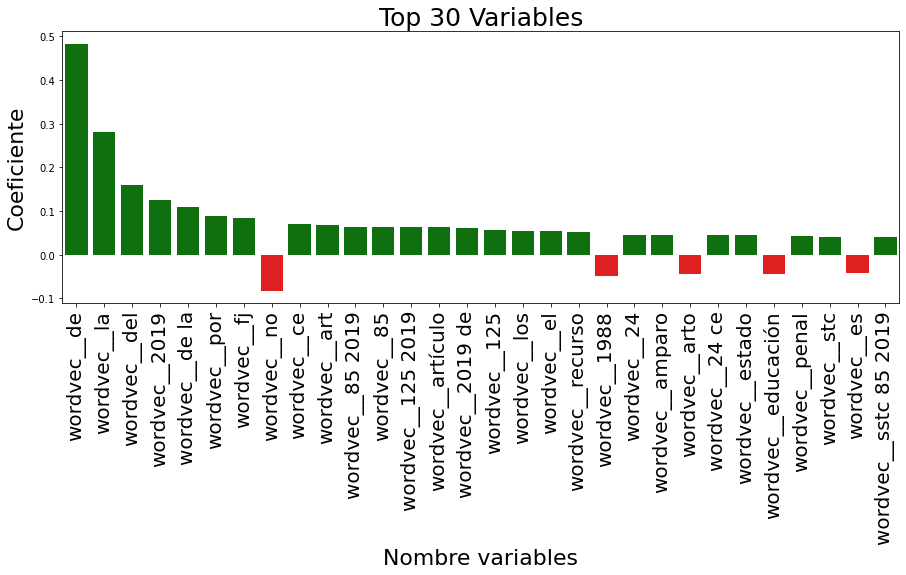

Precision: 0.7

Classification report:
               precision    recall  f1-score   support

desfavorable       0.15      0.78      0.25         9
   favorable       0.98      0.69      0.81       131

    accuracy                           0.70       140
   macro avg       0.56      0.74      0.53       140
weighted avg       0.93      0.70      0.78       140


CR: (0.56371539693434, 0.7362171331636981, 0.53125, None)

Matriz de confusion:
 [[ 7  2]
 [40 91]]


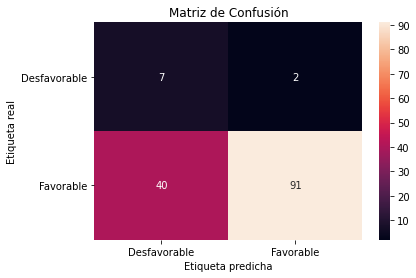



_______________________


Entrenado sobre: antecedentes+fundamentos

Entrenando sobre 38 casos favorables + 38 casos desfavorables = 76 cases 
Sentencias disponibles para testear: 131 favorables + 9  desfavorables
***TEST***
['desfavorable' 'favorable']


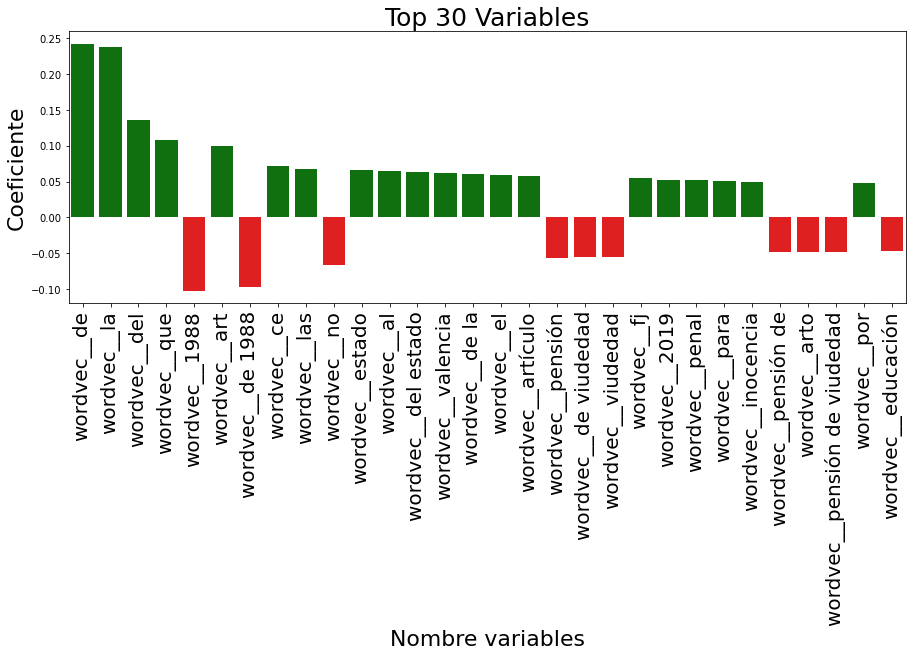

Precision: 0.7285714285714285

Classification report:
               precision    recall  f1-score   support

desfavorable       0.13      0.56      0.21         9
   favorable       0.96      0.74      0.84       131

    accuracy                           0.73       140
   macro avg       0.54      0.65      0.52       140
weighted avg       0.91      0.73      0.80       140


CR: (0.5443005839045443, 0.6480067854113656, 0.5222701149425287, None)

Matriz de confusion:
 [[ 5  4]
 [34 97]]


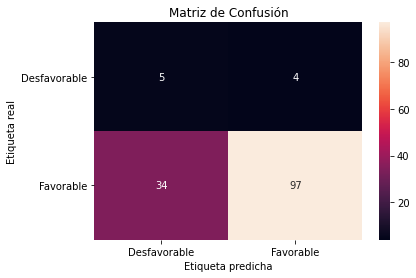



_______________________


Entrenado sobre: todo

Entrenando sobre 38 casos favorables + 38 casos desfavorables = 76 cases 
Sentencias disponibles para testear: 131 favorables + 9  desfavorables
***TEST***
['desfavorable' 'favorable']


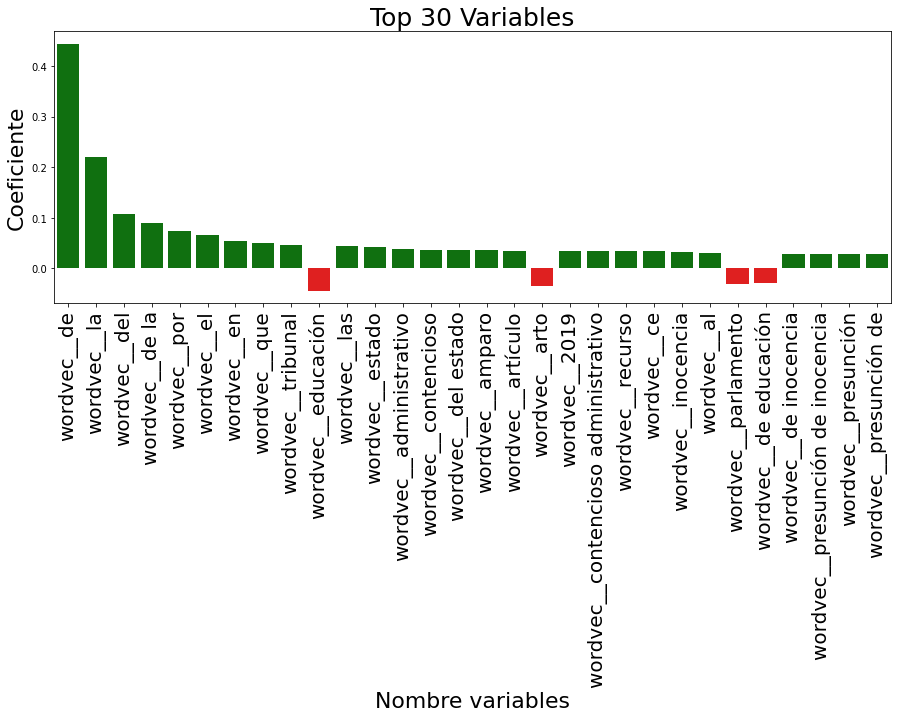

Precision: 0.5571428571428572

Classification report:
               precision    recall  f1-score   support

desfavorable       0.10      0.78      0.18         9
   favorable       0.97      0.54      0.70       131

    accuracy                           0.56       140
   macro avg       0.54      0.66      0.44       140
weighted avg       0.92      0.56      0.66       140


CR: (0.5385401758331629, 0.6598812553011026, 0.44014447884416924, None)

Matriz de confusion:
 [[ 7  2]
 [60 71]]


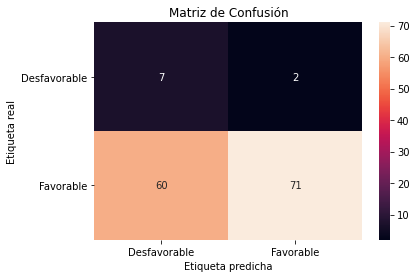



_______________________




In [237]:
from nlkt import stopwords
stop_words = stopwords.words('spanish') #N

articles = ['Articulo 24.1', 
            'Articulo 24.2',
            'Articulo 14']

partes_sentencia = ['intro+composicion_tribunal',
                    'contexto',
                    'antecedentes',
                    'fundamentos',
                    'antecedentes+fundamentos',
                    'todo']

if __name__ == "__main__":
    
    #Indicar ruta donde se encuentran los datos
    path = '/Users/carlosortega/Desktop/TFG Analytics/'
    
    for article in articles:
        print (article + '\n_________________\n_________________\n')
        for parte in partes_sentencia:
            vec = ('wordvec', TfidfVectorizer(analyzer = 'word', ngram_range = (1,3), binary = False, lowercase = True, max_df = 0.9, min_df = 2, norm = 'l2', stop_words = None, use_idf = True))
            c = 0.1
            run_pipeline(parte, vec, c)
#        if article == 'Articulo 24.2':
#            vec = ('wordvec', TfidfVectorizer(analyzer = 'word', ngram_range = (1,2), binary = False, lowercase = True, min_df = 2, norm = 'l2', stop_words = None, use_idf = True))
#            c = 0.1
#            run_pipeline('antecedentes', vec, c)

### Primeras conclusiones

#### Removing stopwords
Eliminar las stopwords no mejora la performance del modelo

#### N-grams
Óptimo: 1-3 n-grams

#### Partes
Entrenar sobre toda la sentencia da malos resultados

La mejor performance para artículos 24.1 y 24.2 es la de 'Antecedente de hecho', 

En relacion al artículo 24.2, la introducción + composicion del tribunal resulta tener muy buena especificidad (bueno detectando casos desfavorables). Cuando el test set está balanceado la accuracy también es muy buena.



#### Unbalanced training set
Es importante dotar al modelo de un training set equilibrado, esto es, que el número de casos de una categoría sea similar al número de casos de la otra. De esta manera evitamos que el modelo se entrene en exceso con datos de una de ellas y luego no tenga buena separabilidad, por lo que acabará prediciendo casi todos los casos con aquella etiqueta que era más abundante a la hora de ser entrenado.

Para ello he cogido el número de casos de ambas categorías, he escogido el menor de dichos números y he establecido un training set del 80% de dicho número para los casos de ambas categorías. Es decir, si el numero de casos dentro de un artículo es 300 Favorables y 70 Desfavorables, el training set será 70*0.8 = 56 casos favorables y 56 desfavorables.

#### Unbalanced test set
A la hora de decidir si balanceamos o no el test set, esta decisión dependeo mucho de:
1. El uso que queramos darle al modelo
2. Las métricas que vayamos a escoger para medir su performance. Si escogemos métricas como Sensitividad y Especificidad, el hecho de que el test set este desproporcionado no es un problema (siempre que haya suficiente número de casos en las etiquetas como para que dichas métricas sean representativas). Sin embargo, si la métrica que utilizamos es la accuracy, ésta sí se verá afectada por un test set desequilibrado.

Dado que los Artículos 24.2 y 14 tienen pocos casos, prefiero tener un test set desequilibrado que al menos me permita validar el modelo sobre un número representativo de casos para los que tienen la etiqueta de veredicto "Favorable"


#### Feature importance
Art 24.1 y 24.2: cuando los antecedentes o el contexto tratan asuntos de años previos.

En el artículo 24.1 además, el relativo a la 'tutela judicial efectiva', cuando los antecedentes de hecho contienen terminos relacionados con recursos de casación así como con el Tribunal Supremo, existe una probabilidad más alta de que el caso termine siendo dictado como Desfavorable. Esto quiere decir que el Tribunal Constitucional tiende a no considerar vulnerado el derecho a la tutela judicial efectiva cuando esta pretensión sucede a partir de un recurso de casación (Tribunal Supremo)

Art 24.1: Así también las referencias a la Ley de Enjuiciamiento Civil inclinan la predicción más hacia el sentido 'Favorable'


#### Cross validation
Muy importante pasar un dataset que este balanceado, aquí como se le da el dataset completo para que el haga los splits con train y test,
